In [2]:
from __future__ import print_function
import keras,sklearn
# suppress tensorflow compilation warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow.compat.v1 as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
seed=0
np.random.seed(seed) # fix random seed
tf.compat.v1.set_random_seed(seed)
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import requests
import io

Using TensorFlow backend.


In [3]:
#load model from server
url_main = 'https://physics.bu.edu/~warsh/ML_QD/'
modelfile = 'model_200000samps.h5'

response = requests.get(url_main + modelfile)
response.raise_for_status()

model_200k = load_model(io.BytesIO(response.content))

In [4]:
#load model from local dir
mod_dir = 'C:/Users/Warsh/ML_Notebooks_edited/mlqdproj/models/'
modelfile = 'model_40000samps.h5'

model_40k = load_model(mod_dir + modelfile)

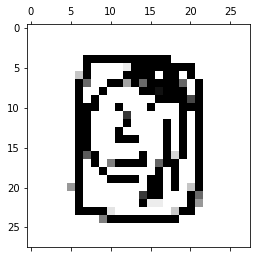

CNN classified as the mona lisa


In [5]:
#pictionary cell
#run cell, draw with mouse, use right click to change between eraser and draw mode, esc to close window
#dont use the file save thing until you set it up for your computer
#to use file save stuff just set saveset = True
saveset = False
#which model?
model = model_200k


import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

drawing = False # true if mouse is pressed
mode = False # if True, draw rectangle. Press 'm' to toggle to curve
ix,iy = -1,-1
brushsize=10
ersize=20

# mouse callback function
def draw_circle(event,x,y,flags,param):
    global ix,iy,drawing,mode

    #this is eraser
    if event == cv2.EVENT_RBUTTONDOWN:
        mode = not(mode)
        ix,iy = x,y
            
    #and this is for drawing
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix,iy = x,y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            if mode == True:
                cv2.circle(img,(x,y),ersize,(255,255,255),-1)
            else:
                cv2.circle(img,(x,y),brushsize,(0,0,0),-1)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        if mode == True:
            cv2.circle(img,(x,y),ersize,(255,255,255),-1)
        else:
            cv2.circle(img,(x,y),brushsize,(0,0,0),-1)
            
#create image and a window and bind the function to window
img = np.zeros((512,512,3), np.uint8)
cv2.namedWindow('draw something!')
cv2.circle(img,(255,255),400,(255,255,255),-1)
cv2.setMouseCallback('draw something!',draw_circle)
while(1):
    cv2.imshow('draw something!',img)
    if cv2.waitKey(20) & 0xFF == 27:
        break

#convert to usable
rgb_weights = [0.2989, 0.5870, 0.1141]
gs_img = abs(255-np.dot(img[...,:3], rgb_weights))
gs_img /= 255
lowres = cv2.resize(gs_img, dsize=(28, 28), interpolation=cv2.INTER_LINEAR)

#file saving stuff
if saveset==True:
    picname = 'C:/Users/Warsh/ML_Notebooks_edited/drawings/niceimage'
    savfil = picname
    i=1
    yeet=False
    while yeet==False:
        if os.path.exists(savfil+'.png')==True:
            savfil = picname+str(i)
            i=i+1
        else:
            cv2.imwrite(savfil+'.png',gs_img*255)
            cv2.imwrite(savfil+'cov.png',lowres*255)
            yeet=True

#close windows
cv2.destroyAllWindows()

#look at 28x28 version of drawing
plt.matshow(lowres.reshape(28,28),cmap='binary')
plt.show()

#reshape to 4D array, predict with the trained CNN
lowres_rshp=lowres.reshape(1,28,28,1)
yokay=['an airplane', 'the mona lisa','a dragon','a giraffe']
cat=model.predict(lowres_rshp).argmax(1)
print('CNN classified as',yokay[cat[0]])